# Stick-Breaking Process and Dirichlet Process

In [5]:
import string
import numpy as np
import matplotlib.pyplot as plt
from math import isclose

In [212]:
plt.rc('axes', titlesize=18)     # fontsize of the axes title
plt.rc('axes', labelsize=18)    # fontsize of the x and y labels

# A. Dirichlet Distribution

A multivariate generalization of the beta distribution is the Dirichlet distribution, which has support over the probability simples, defined by

\begin{align}
\triangle_{K} = \{C: C_{k}\geq 0, \sum_{k=1}^{K}C_{k}=1\}
\end{align}

The pdf is defined as follows:

\begin{align}
Dir(C|\alpha) \triangleq \frac{\prod_{k=1}^{K}C_{k}^{\alpha_{k}-1}\mathbb{I}(C \in \triangle_{K})}{B(\alpha)}
\end{align}

In [209]:
def dirichlet(alpha, k, seed=0):
    np.random.seed(seed)
    C = np.random.dirichlet(alpha*np.ones(k), size=1).flatten()
    return C

def plot_dirichlet(C, alpha):
    m, n = C.shape
    letters = string.ascii_lowercase[:n+1]
    fig, axs = plt.subplots(m, n, figsize=(12,16))
    plt.subplots_adjust(hspace=0.3, wspace=0.3)
    for i in range(m):
        for j in range(n):
            axs[i,j].bar(range(1, len(C[i,j])+1), C[i,j], width=0.7, color="darkblue")
            axs[i,j].spines['right'].set_visible(False)
            axs[i,j].spines['top'].set_visible(False)
            if i==0:
                axs[i,j].set_title(rf"$\alpha$={alpha[j]}")
            if i==m-1:
                axs[i,j].set_xlabel(f"({letters[j]})")
    plt.show()

In [210]:
alpha = [0.1, 1, 10]
K = [2, 5, 10, 100, 1000]
C = np.array([[dirichlet(a, k, seed=0) for a in alpha] for k in K])

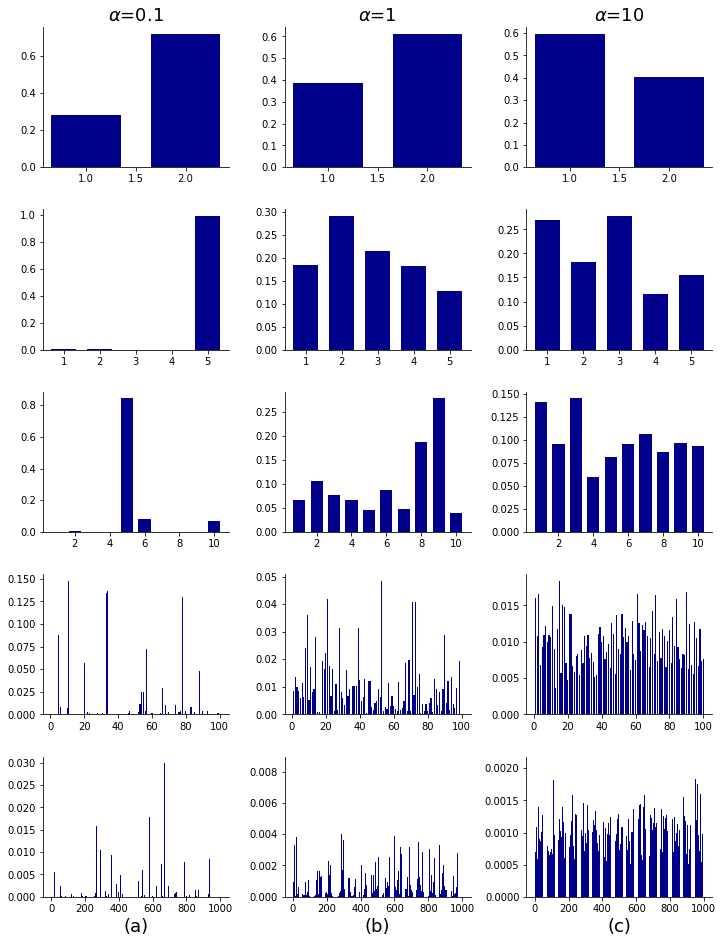

In [213]:
plot_dirichlet(C, alpha)

**Figure 1**: Samples from a symmetric Dirichlet Distribution, that is $Dir(\frac{\alpha}{K}1_{K})$, with $\alpha\in\{0.1, 1, 1\}$ and $K\in\{2, 5, 10, 100, 1000\}$.

In Figure 1 we have samples from a symmetric Dirichlet Distribution, lower $\alpha$ results in very sparse distribution, with many zeros and high variance, while higher $\alpha$ makes the size of the atoms more similar with higher density in the center of the simplex, note that with $\alpha=1$ the distribution is uniform over the simplex (i.e. no region with higher density). In addition, a higher dimension results in less variance and decrease in the size of the atom because there are more dimensions over which the mass must be distributed.

# B. Stick-Breaking Process
If the number $K$ of mixture components is infinite, we can sample from a distribution $H$ on $[0,1]$ and we break a large bar by 1 in two, then we sample from H again and we break the rest of the bar in two and so on. This process end with probability 1 and when $H=Beta(1, \alpha)$ this process is called stick-breaking, defined by

\begin{align}
& V_{1}, V_{2}, \ldots \sim_{iid} Beta(1, \alpha)\\
& C_{k} = V_{k}\prod_{j=1}^{k-1}(1-V_{k})\\
\end{align}

Note: in practice, when we sample from this distribution we need to add a tolerance (1e-8) so that the process ends in a reasonable number of steps.

In [214]:
def stick_breaking(alpha, seed=0):
    np.random.seed(seed)
    V = []
    C = []
    while not isclose(sum(C), 1, rel_tol=1e-8):
        # V_k~beta(1,alpha)
        V.append(np.random.beta(1, alpha))
        # C_k=V_k*\prod_{j=1}^{k-1}(1-V_j)
        rest = (1-np.array(V[:-1])).prod()
        C.append(V[-1]*rest)
    return np.array(C)

# C. Dirichlet Process

If $\alpha>0$ and if $G$ is a probability measure on $\Omega_{\phi}$ the random discrete probability measure $\Theta:=\sum C_{k}\delta_{\Phi_{k}}$ generated by

\begin{align}
& V_{1}, V_{2}, \ldots \sim_{iid} Beta(1, \alpha)\\
& C_{k} = V_{k}\prod_{j=1}^{k-1}(1-V_{k})\\
& \Phi_{1}, \Phi_{2}, \ldots \sim_{iid} G_{0}
\end{align}

is called a Dirichlet Process (DP) with base measure $G$ and concentration paremeter $\alpha>0$, and we denote its law by $DP(\alpha, G_{0})$.

## C1. Base Measure

We will sample from a dirichlet process with base measure $\mathcal{N}(0, 1)$.

In [215]:
def dirichlet_process(alpha, mu=0, sigma=1, seed=0):
    # atoms sizes
    C = stick_breaking(alpha, seed=seed)
    # gaussian base measure
    np.random.seed(seed)
    Phi = np.array([np.random.normal(mu,sigma) for C_k in C]) 
    return C, Phi

In [216]:
alpha = [0.1, 0.2, 0.6, 6, 60]
seed = [9, 7, 100, 0, 0]
m = len(alpha)
Theta = np.array([dirichlet_process(alpha[i], seed=seed[i]) for i in range(M)])
C = Theta[:,0]
Phi = Theta[:,1]

In [217]:
def plot_dp(Theta, alpha):
    C = Theta[:,0]
    Phi = Theta[:,1]
    m = len(alpha)
    fig, axs = plt.subplots(m, 2, figsize=(8,16))
    plt.subplots_adjust(hspace=0.3, wspace=0.3)
    for i in range(m):
        
        axs[i,0].bar(range(1, len(C[i])+1), C[i], width=0.7, color="darkblue")
        axs[i,0].spines['right'].set_visible(False)
        axs[i,0].spines['top'].set_visible(False)
        axs[i,0].set_title(rf"$\alpha$={alpha[i]}")
        if i==M-1:
            axs[i,0].set_xlabel("(a)")
        
        axs[i,1].vlines(x=Phi[i], ymin=0, ymax=C[i], color='black', linewidth=1.3)
        axs[i,1].scatter(x=Phi[i], y=C[i], s=75, color='darkblue')
        axs[i,1].spines['right'].set_visible(False)
        axs[i,1].spines['top'].set_visible(False)
        axs[i,1].set_title(rf"$\alpha$={alpha[i]}")
        if i==m-1:
            axs[i,1].set_xlabel("(b)")
    plt.show()

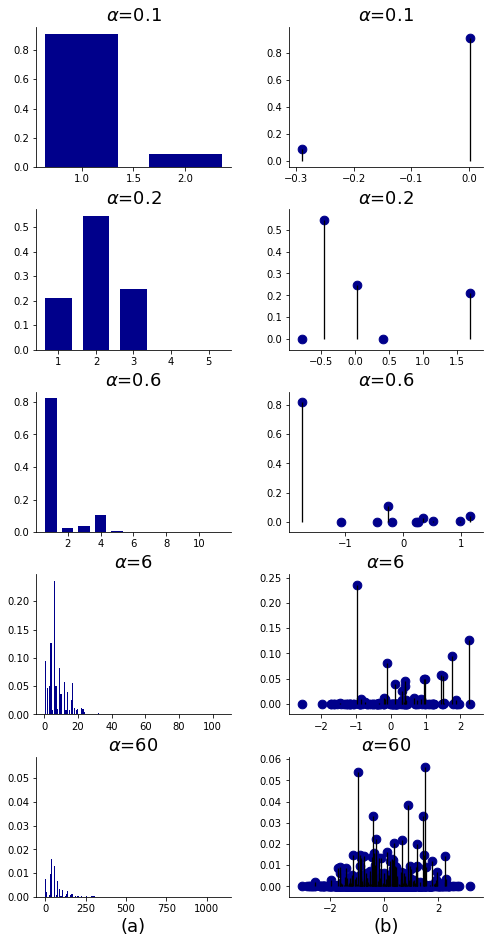

In [218]:
plot_dp(Theta, alpha)

**Figure 2**: Random measures sample from a Dirichlet process with normal base measure $\mathcal{N}(0,1)$ with concentration parameter $\alpha\in\{0.1, 0.2, 0.6, 6, 60\}$. (a) Samples from stick-breaking process. (b) Samples from Dirichlet process with those mixture weights.

In Figure 2 we have some samples from a stick-breaking process (left) and dirichlet process  (right) with base measure $\mathcal{N}(0, 1)$ with concentration parameter $\alpha\in\{0.1, 0.2, 0.6, 6, 60\}$. The higher the alpha, the less variance and the greater number of atoms, on the contrary, small values of alpha show a high variance and a lower number of atoms, additionally they show a greater variance in the number of atoms according to the random seed. 

# D. Sampling 


We want to sample from $\Theta \sim Dir(\alpha, G)$ by $N$ times:

\begin{align}
\Theta := \sum C_{k}\delta_{\Phi_{k}}
\end{align}

from the stick-breaking process we know $C_{1:K}$ and $\Phi_{1:K}$, where $K$ is finite with probability 1, then we can sample from this discrete distribution a sequence $\phi_{1}, \phi_{2}, \ldots$ by:

\begin{align}
L_{i}\sim Mult(C)\\
\phi_{i} = \Phi_{L_{i}}
\end{align}

In [219]:
def sampling(C, Phi, N):
    L = np.random.choice(list(range(len(C))), N, p=C)
    return Phi[L]

def norm_samples(samples):
    N = len(samples)
    x, y = np.unique(samples, return_counts=True)
    y = y/N
    return x, y

In [220]:
N = [2, 10, 200, 500, 2000]
samples = np.array([[sampling(C[i], Phi[i] , n) for i in range(M)] for n in N])

In [225]:
def plot_samples(samples, alpha, N):
    m, n = samples.shape
    letters = string.ascii_lowercase[:n+1]
    fig, axs = plt.subplots(m, n, figsize=(20,20))
    plt.subplots_adjust(hspace=0.3, wspace=0.3)
    for i in range(m):
        for j in range(n):
            x, y = norm_samples(samples[i,j])
            axs[i,j].vlines(x=x, ymin=0, ymax=y, color='black', linewidth=1.3)
            axs[i,j].scatter(x=x, y=y, s=75, color='darkblue')
            axs[i,j].spines['right'].set_visible(False)
            axs[i,j].spines['top'].set_visible(False)
            if i==0:
                axs[i,j].set_title(rf"$\alpha$={alpha[j]}")
            if i==m-1:
                axs[i,j].set_xlabel(f"({letters[j]})")
            if j==0:
                axs[i,j].set_ylabel(f"N={N[i]}")
    plt.show()

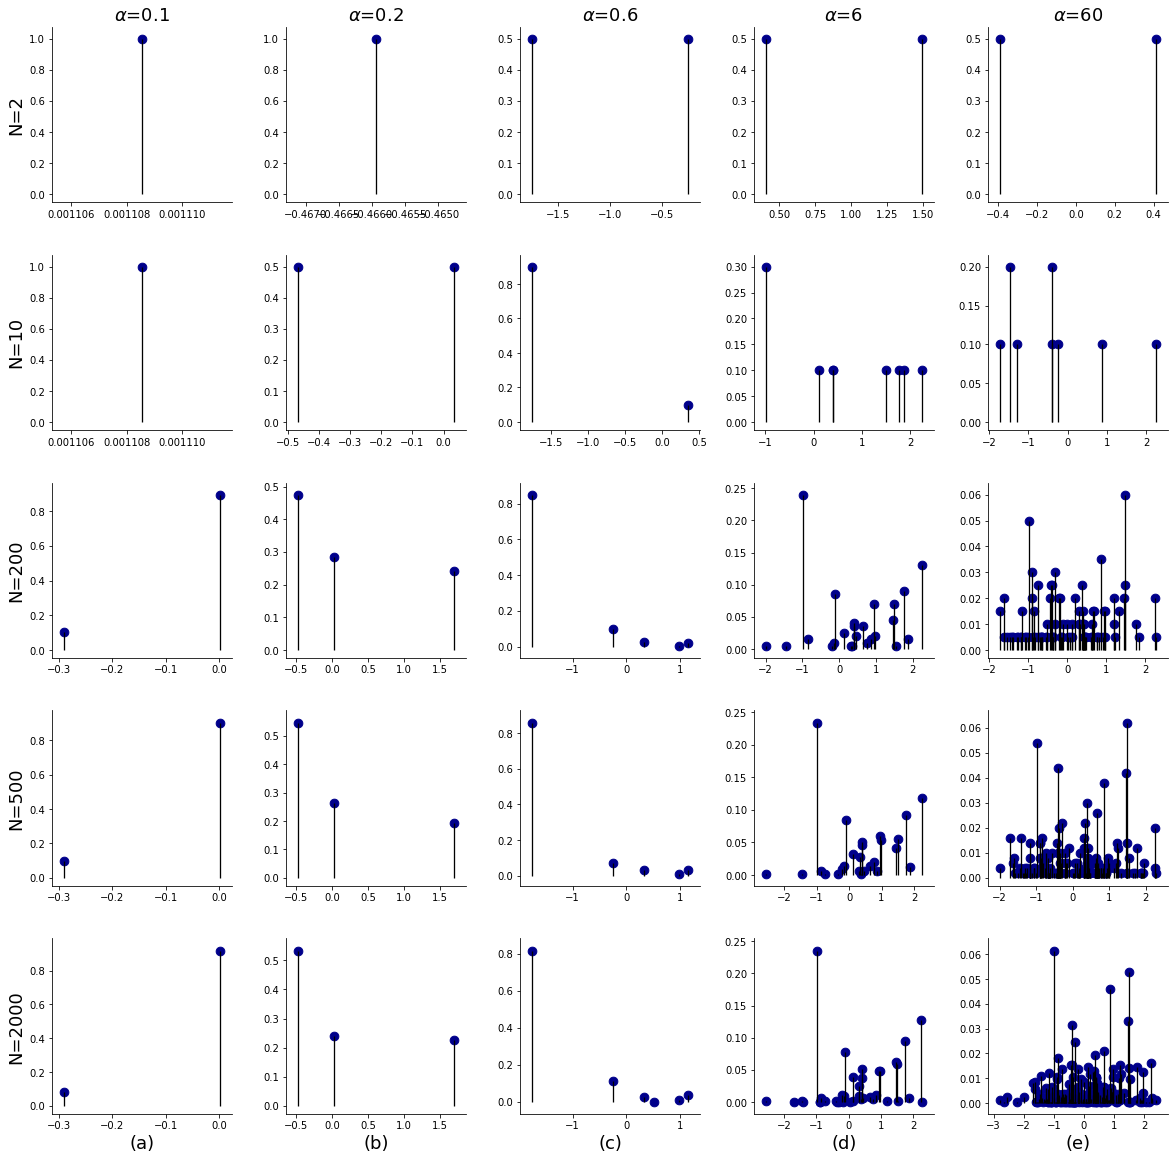

In [226]:
plot_samples(samples, alpha, N)

**Figure 3**: Samples from random measures samples from a Dirichlet Process with ormal base measure $\mathcal{N}(0,1)$ with concentration parameter $\alpha\in\{0.1, 0.2, 0.6, 6, 60\}$. The atom sizes is normalized based on the number of samples.

In Figure 3 we have some samples from random measures sampled from a Dirichlet Process. To higher $N$ the possibility of repeating a previous $\phi$ is greater and this occurs with greater probability for smaller $\alpha$, this is because the number of possibilities/atoms is less. In addition, to higher $N$ the empirical distribution converge to the true discrete distribution.